In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
#load train, test, and validation sets
train_df = pd.read_csv('/content/drive/MyDrive/liar_dataset/train.tsv', sep='\t')
test_df = pd.read_csv('/content/drive/MyDrive/liar_dataset/test.tsv', sep='\t')
val_df = pd.read_csv('/content/drive/MyDrive/liar_dataset/valid.tsv', sep='\t')

In [ ]:
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']
train_df.columns = columns
val_df.columns = columns
test_df.columns = columns
train_df.head()

id        label                                          statement  \
0  10540.json    half-true  When did the decline of coal start? It started...   
1    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
2   1123.json        false  Health care reform legislation is likely to ma...   
3   9028.json    half-true  The economic turnaround started at the end of ...   
4  12465.json         true  The Chicago Bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   charlie-crist   
4                           education       robin-vos   

                          job      state       party  barely_true_counts  \
0              State delegate   Virginia    democrat                 0.0   
1                   President   Illinois    democrat                70.0   
2                         NaN        NaN        none                 7.0   
3                         NaN    Florida    democrat                15.0   
4  Wisconsin Assembly speaker  Wisconsin  republican                 0.0   

   false_counts  half_true_counts  mostly_true_counts  pants_on_fire_counts  \
0           0.0               1.0                 1.0                   0.0   
1          71.0             160.0               163.0                   9.0   
2          19.0               3.0                 5.0                  44.0   
3           9.0              20.0                19.0                   2.0   
4           3.0               2.0                 5.0                   1.0   

                     context  
0            a floor speech.  
1                     Denver  
2             a news release  
3        an interview on CNN  
4  a an online opinion-piece

In [ ]:
#handling missing/inconsistent data
train_df.info()
train_df.describe(include='all')
train_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10239 non-null  object 
 1   label                 10239 non-null  object 
 2   statement             10239 non-null  object 
 3   subject               10237 non-null  object 
 4   speaker               10237 non-null  object 
 5   job                   7341 non-null   object 
 6   state                 8029 non-null   object 
 7   party                 10237 non-null  object 
 8   barely_true_counts    10237 non-null  float64
 9   false_counts          10237 non-null  float64
 10  half_true_counts      10237 non-null  float64
 11  mostly_true_counts    10237 non-null  float64
 12  pants_on_fire_counts  10237 non-null  float64
 13  context               10137 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


id                         0
label                      0
statement                  0
subject                    2
speaker                    2
job                     2898
state                   2210
party                      2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
dtype: int64

In [ ]:
train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

In [ ]:
#combine all dataset for eda
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df.head()

id        label                                          statement  \
0  10540.json    half-true  When did the decline of coal start? It started...   
1    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
2   1123.json        false  Health care reform legislation is likely to ma...   
3   9028.json    half-true  The economic turnaround started at the end of ...   
4  12465.json         true  The Chicago Bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   charlie-crist   
4                           education       robin-vos   

                          job      state       party  barely_true_counts  \
0              State delegate   Virginia    democrat                 0.0   
1                   President   Illinois    democrat                70.0   
2                         NaN        NaN        none                 7.0   
3                         NaN    Florida    democrat                15.0   
4  Wisconsin Assembly speaker  Wisconsin  republican                 0.0   

   false_counts  half_true_counts  mostly_true_counts  pants_on_fire_counts  \
0           0.0               1.0                 1.0                   0.0   
1          71.0             160.0               163.0                   9.0   
2          19.0               3.0                 5.0                  44.0   
3           9.0              20.0                19.0                   2.0   
4           3.0               2.0                 5.0                   1.0   

                     context  split  
0            a floor speech.  train  
1                     Denver  train  
2             a news release  train  
3        an interview on CNN  train  
4  a an online opinion-piece  train

In [ ]:
#initial data inspection
print(full_df.info())
print(full_df.describe(include='all'))
print(full_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12788 entries, 0 to 12787
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12788 non-null  object 
 1   label                 12788 non-null  object 
 2   statement             12788 non-null  object 
 3   subject               12786 non-null  object 
 4   speaker               12786 non-null  object 
 5   job                   9220 non-null   object 
 6   state                 10037 non-null  object 
 7   party                 12786 non-null  object 
 8   barely_true_counts    12786 non-null  float64
 9   false_counts          12786 non-null  float64
 10  half_true_counts      12786 non-null  float64
 11  mostly_true_counts    12786 non-null  float64
 12  pants_on_fire_counts  12786 non-null  float64
 13  context               12657 non-null  object 
 14  split                 12788 non-null  object 
dtypes: float64(5), obje

In [ ]:
#data cleaning
#remove duplicate
duplicates = full_df[full_df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")



Number of duplicate rows: 0


In [ ]:
# handle missing data
# drop rows withfew missing values
minor_missing_cols = [
    'subject', 'speaker', 'party',
    'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts'
]
full_df = full_df.dropna(subset=minor_missing_cols)


full_df['job'] = full_df['job'].fillna('unknown_job')
full_df['state'] = full_df['state'].fillna('unknown_state')
full_df['context'] = full_df['context'].fillna('unknown_context')

In [ ]:
full_df.isnull().sum()

id                      0
label                   0
statement               0
subject                 0
speaker                 0
job                     0
state                   0
party                   0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
split                   0
dtype: int64

In [ ]:
#check unique labels
full_df['label'].value_counts()

label
half-true      2627
false          2504
mostly-true    2454
barely-true    2102
true           2052
pants-fire     1047
Name: count, dtype: int64

In [ ]:
#simplifying labels
true_labels = ['true', 'mostly-true', 'half-true']
false_labels = ['false', 'pants-fire', 'barely-true']

train_df["binary_label"] = train_df["label"].apply(lambda x: "true" if x in true_labels else "false")
val_df["binary_label"] = val_df["label"].apply(lambda x: "true" if x in true_labels else "false")
test_df["binary_label"] = test_df["label"].apply(lambda x: "true" if x in true_labels else "false")

In [ ]:



true_labels = ['true', 'mostly-true']
false_labels = ['false', 'pants-fire', 'barely-true']

full_df["binary_label"] = full_df["label"].apply(lambda x: "true" if x in true_labels else "false")

#check class distribution
print("label distribution")
print(full_df['label'].value_counts())


print("\nbinary label distribution")
print(full_df['binary_label'].value_counts())

label distribution
label
True           2627
false          2504
mostly-true    2454
barely-true    2102
true           2052
pants-fire     1047
Name: count, dtype: int64

binary label distribution
binary_label
false    8280
true     4506
Name: count, dtype: int64


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatize and remove stopwords
    return text

full_df['clean_text'] = full_df['statement'].apply(clean_text)
full_df[['statement', 'clean_text']].head()

statement  \
0  When did the decline of coal start? It started...   
1  Hillary Clinton agrees with John McCain "by vo...   
2  Health care reform legislation is likely to ma...   
3  The economic turnaround started at the end of ...   
4  The Chicago Bears have had more starting quart...   

                                          clean_text  
0  decline coal start started natural gas took st...  
1  hillary clinton agrees john mccain voting give...  
2  health care reform legislation likely mandate ...  
3               economic turnaround started end term  
4  chicago bear starting quarterback last year to...

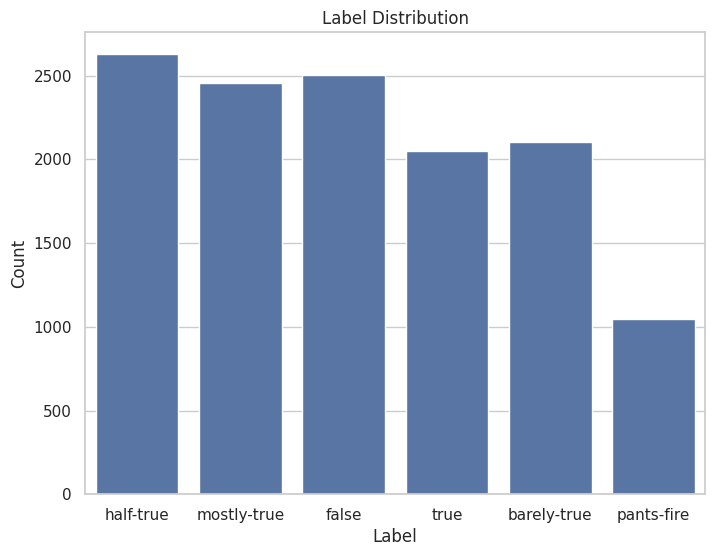

In [ ]:
# original 6 way label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=full_df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-797544357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='binary_label', data=full_df, palette='Set2')


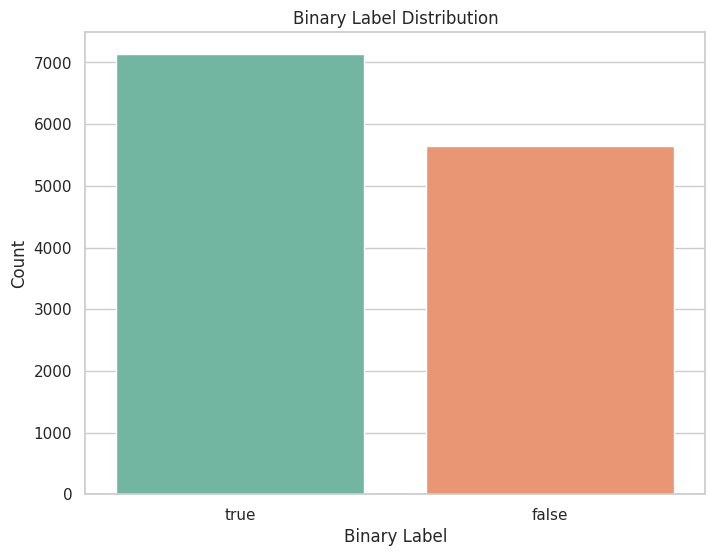

In [ ]:
#binary label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='binary_label', data=full_df, palette='Set2')
plt.title('Binary Label Distribution')
plt.xlabel('Binary Label')
plt.ylabel('Count')
plt.show()

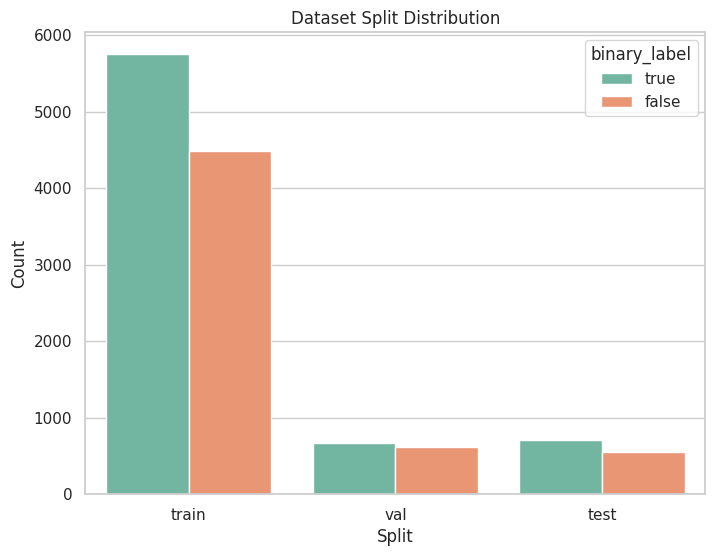

In [ ]:
#distribution by dataset split
plt.figure(figsize=(8, 6))
sns.countplot(x="split", data=full_df,hue="binary_label", palette='Set2')
plt.title('Dataset Split Distribution')
plt.xlabel('Split')
plt.ylabel('Count')
plt.show()

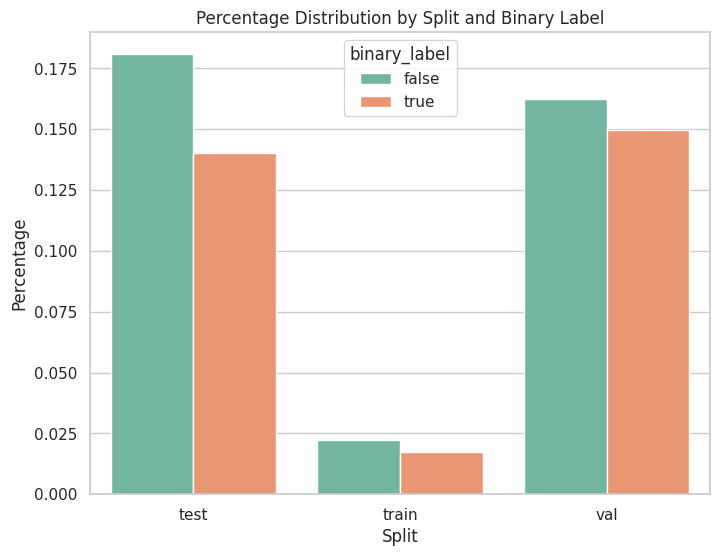

In [ ]:
#percentage distribution by split
split_percent = (
    full_df.groupby(['split', 'binary_label'])
    .value_counts(normalize=True)
    .rename('percent')
    .mul(100)
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(x='split', y='percent', hue='binary_label', data=split_percent, palette='Set2')
plt.title('Percentage Distribution by Split and Binary Label')
plt.xlabel('Split')
plt.ylabel('Percentage')
plt.show()

Text Analysis

In [ ]:
#text statistics
full_df["word_count"] = full_df["statement"].apply(lambda x: len(x.split()))
full_df["char_count"] = full_df["statement"].apply(len)
full_df["avg_word_length"] = full_df["statement"].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) >0 else 0)

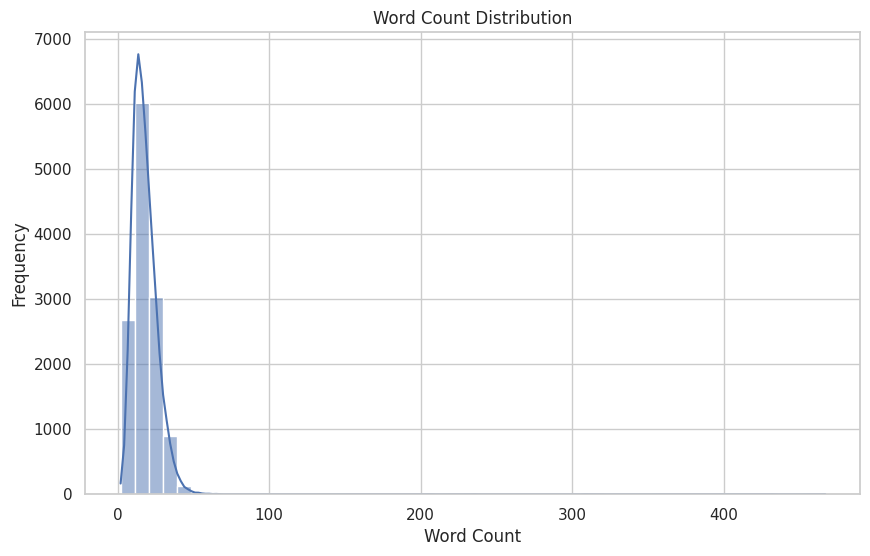

In [ ]:
# word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(full_df["word_count"], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

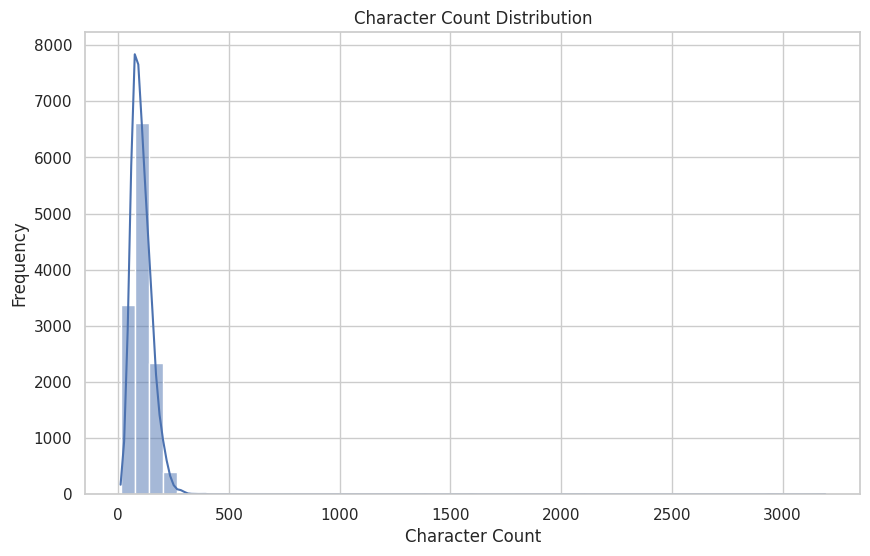

In [ ]:
#character count distribution
plt.figure(figsize=(10, 6))
sns.histplot(full_df["char_count"], bins=50, kde=True)
plt.title("Character Count Distribution")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

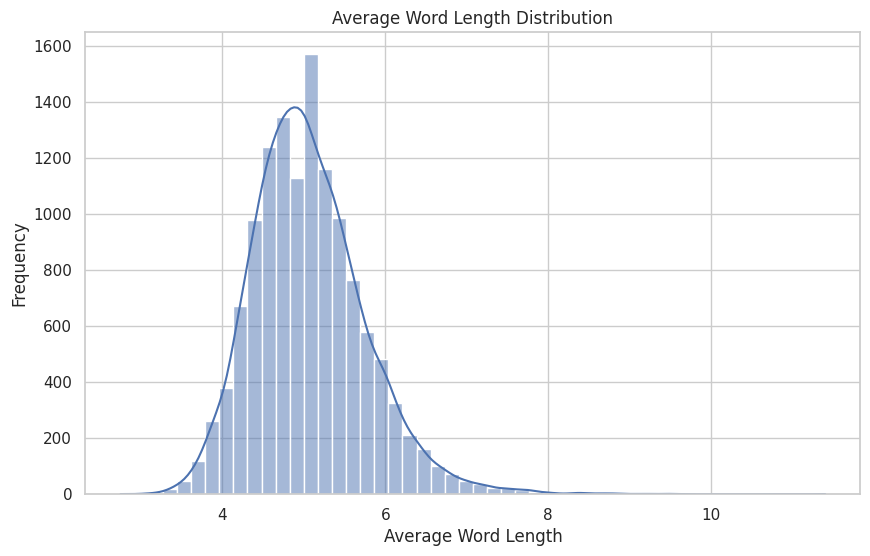

In [ ]:
#average word length
plt.figure(figsize=(10, 6))
sns.histplot(full_df["avg_word_length"], bins=50, kde=True)
plt.title("Average Word Length Distribution")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.show()

/tmp/ipython-input-4271113522.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="word_count", data=full_df, palette='Set2')


<function matplotlib.pyplot.show(close=None, block=None)>

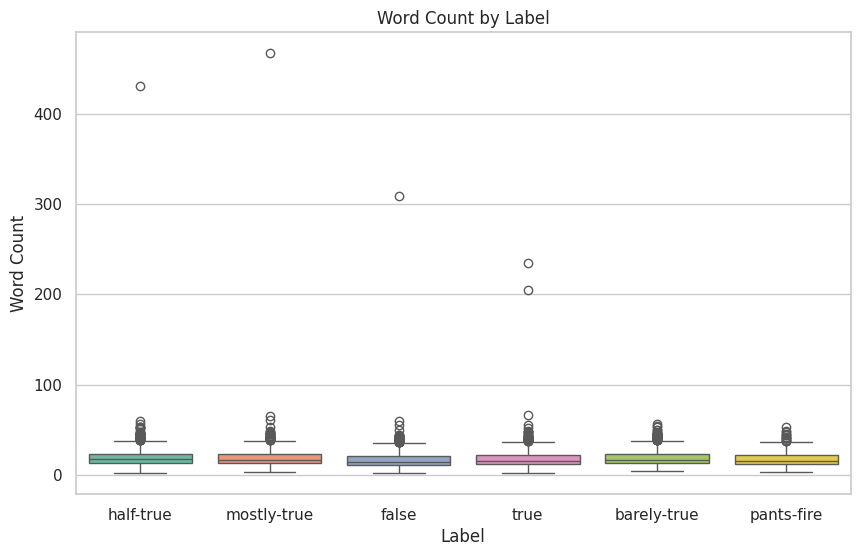

In [ ]:
#word count by label
plt.figure(figsize=(10, 6))
sns.boxplot(x="label", y="word_count", data=full_df, palette='Set2')
plt.title("Word Count by Label")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show

/tmp/ipython-input-752198645.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="char_count", palette='Set2', data=full_df)


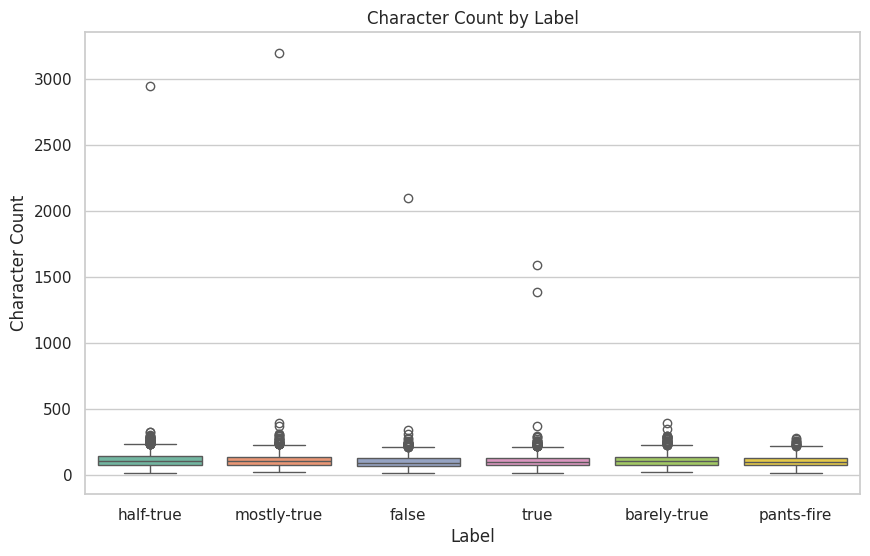

In [ ]:
#box plot comparison for character count
plt.figure(figsize=(10, 6))
sns.boxplot(x="label", y="char_count", palette='Set2', data=full_df)
plt.title("Character Count by Label")
plt.xlabel("Label")
plt.ylabel("Character Count")
plt.show()

In [ ]:
# statistical summary table
summary_table = full_df[["word_count", "char_count", "avg_word_length"]].describe()
summary_table

word_count    char_count  avg_word_length
count  12786.000000  12786.000000     12786.000000
mean      18.034647    107.124589         5.061300
std       10.108568     63.330564         0.696664
min        2.000000     11.000000         2.750000
25%       12.000000     73.000000         4.583333
50%       17.000000     99.000000         5.000000
75%       22.000000    133.000000         5.461538
max      467.000000   3192.000000        11.400000

In [ ]:
#mean comparison by label
mean_comparison = full_df.groupby("label")[["word_count", "char_count", "avg_word_length"]].mean().round(2)
mean_comparison

word_count  char_count  avg_word_length
label                                               
barely-true       18.16      108.35             5.08
false             16.84      100.68             5.11
half-true         18.96      112.74             5.07
mostly-true       18.50      109.18             5.01
pants-fire        17.24      102.94             5.11
true              18.03      106.22             5.00

Speaker characteristics

/tmp/ipython-input-275196320.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.index, y=top_speakers.values, palette='Set2')


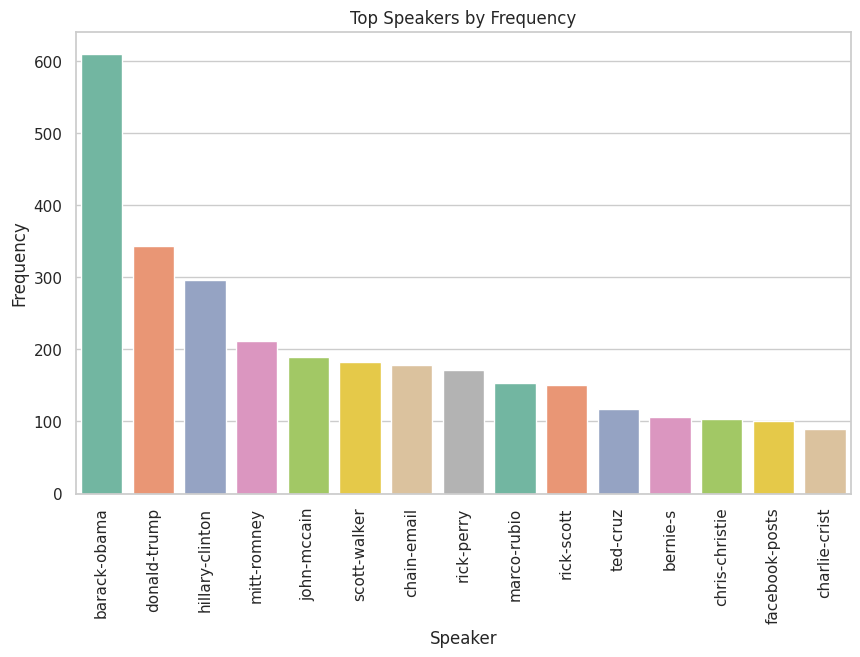

In [ ]:
#Top speakers by frequency
top_speakers = full_df["speaker"].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_speakers.index, y=top_speakers.values, palette='Set2')
plt.title("Top Speakers by Frequency")
plt.xlabel("Speaker")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

Valid credibility scores: 12383 out of 12786 rows


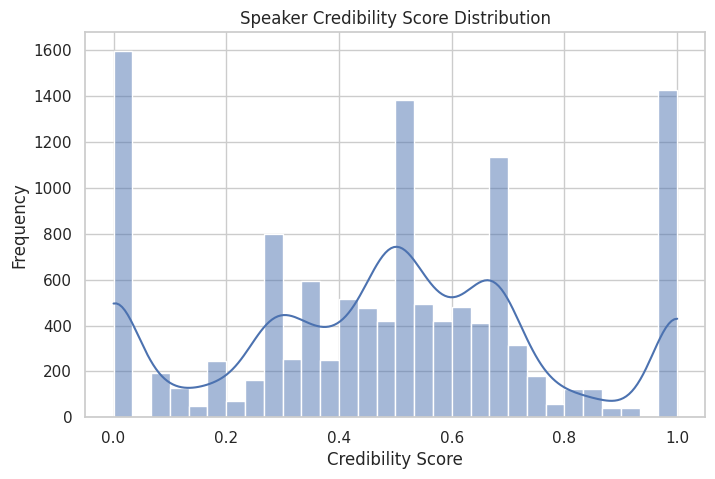

In [ ]:
# speaker credibility distribution
credibility_cols = ["barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts"]

#convert numerical columns to integers
for col in credibility_cols:
  full_df[col] = pd.to_numeric(full_df[col], errors='coerce').fillna(0)

full_df["total_past"] = full_df[credibility_cols].sum(axis=1)
full_df["credible_total"] = full_df["half_true_counts"] + full_df["mostly_true_counts"]

full_df["credibility_score"] = np.where(
    full_df["total_past"] > 0,
    full_df["credible_total"] / full_df["total_past"],
    np.nan
)

credibility_df = full_df.dropna(subset=["credibility_score"])
credibility_df = credibility_df[(credibility_df["credibility_score"] >= 0) & (credibility_df["credibility_score"] <= 1)]

print(f"Valid credibility scores: {len(credibility_df)} out of {len(full_df)} rows")

if len(credibility_df) > 0:
  plt.figure(figsize=(8, 5))
  sns.histplot(full_df["credibility_score"], bins=30, kde=True)
  plt.title("Speaker Credibility Score Distribution")
  plt.xlabel("Credibility Score")
  plt.ylabel("Frequency")
  plt.show()
else:
  print("No valid credibility scores found.")


/tmp/ipython-input-1043738599.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_df, x="binary_label", y="credibility_score", palette="Set2")


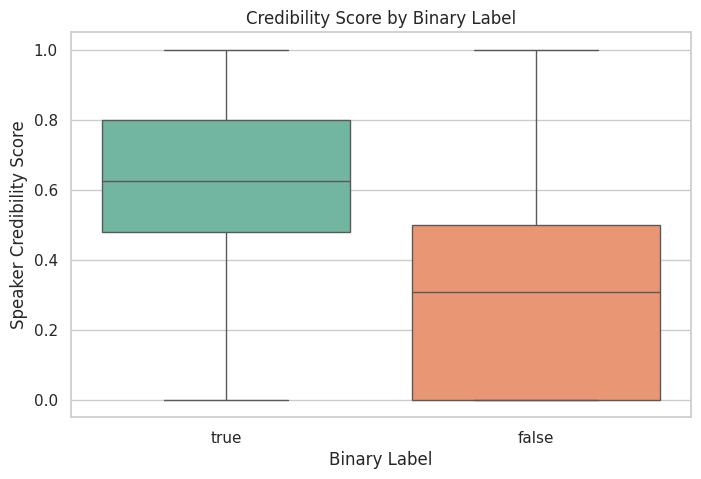

In [ ]:
#Credibility by label
plt.figure(figsize=(8, 5))
sns.boxplot(data=full_df, x="binary_label", y="credibility_score", palette="Set2")
plt.title("Credibility Score by Binary Label")
plt.xlabel("Binary Label")
plt.ylabel("Speaker Credibility Score")
plt.show()

In [ ]:
#Number of unique speakers
unique_speakers = full_df["speaker"].nunique()
print(f" Total Unique Speakers: {unique_speakers}")

 Total Unique Speakers: 3308


/tmp/ipython-input-1045469681.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speaker_credibility.values, y=speaker_credibility.index, palette="crest")


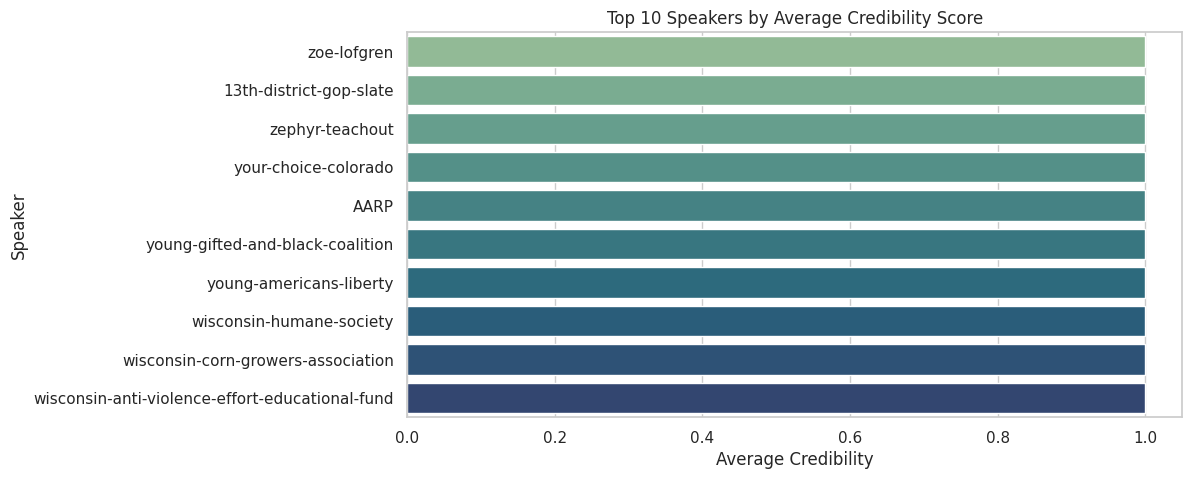

In [ ]:
#Average credibility per speaker (top 10)
speaker_credibility = (
    full_df.groupby("speaker")["credibility_score"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(10, 5))
sns.barplot(x=speaker_credibility.values, y=speaker_credibility.index, palette="crest")
plt.title("Top 10 Speakers by Average Credibility Score")
plt.xlabel("Average Credibility")
plt.ylabel("Speaker")
plt.show()

In [ ]:
#Correlation between credibility and label (encoded)
full_df["label_encoded"] = full_df["binary_label"].map({"true": 1, "false": 0})
correlation = full_df[["credibility_score", "label_encoded"]].corr().iloc[0, 1]
print(f" Correlation between credibility score and truth label: {correlation:.3f}")



 Correlation between credibility score and truth label: 0.548


/tmp/ipython-input-3933727463.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


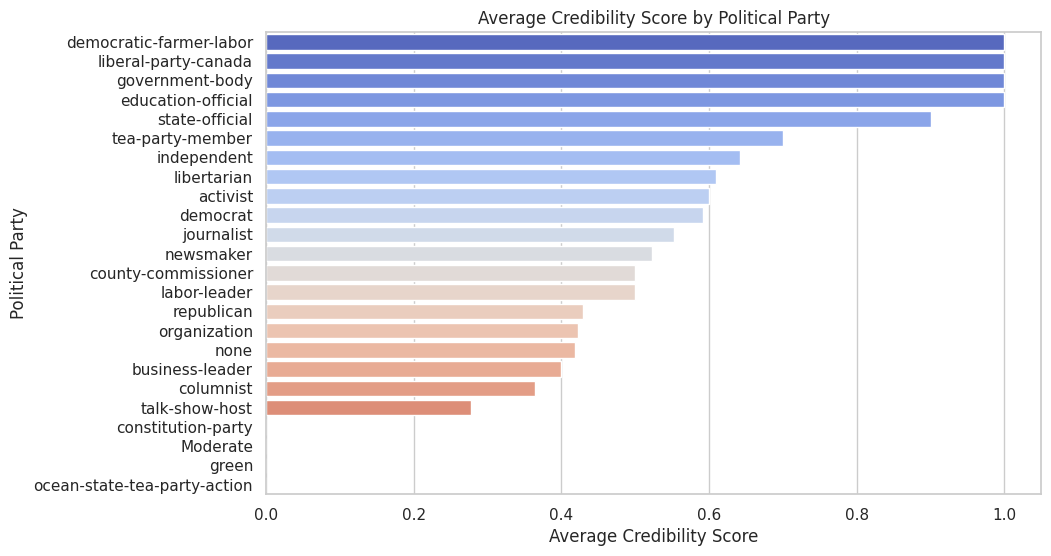

party level credibility summary


party  avg_credibility  speaker_count  total_statements
7   democratic-farmer-labor         1.000000              1                 1
14     liberal-party-canada         1.000000              1                 1
9           government-body         1.000000              2                 2
8        education-official         1.000000              3                 3
21           state-official         0.900000             21                24
23         tea-party-member         0.700000              7                10
11              independent         0.642441             21               180
15              libertarian         0.609149             26                51
1                  activist         0.600000             41                45
6                  democrat         0.591215            896              4137

In [ ]:
# aggregate by political party
party_credibility = (
    full_df.groupby("party")
    .agg(
        avg_credibility=("credibility_score", "mean"),
        speaker_count=("speaker", "nunique"),
        total_statements=("statement", "count")
    )
    .reset_index()
    .dropna(subset=["avg_credibility"])
    .sort_values("avg_credibility", ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=party_credibility,
    y="party",
    x="avg_credibility",
    palette="coolwarm"
)
plt.title("Average Credibility Score by Political Party")
plt.xlabel("Average Credibility Score")
plt.ylabel("Political Party")
plt.show()

print( "party level credibility summary")
display(party_credibility.head(10))

/tmp/ipython-input-2204579015.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


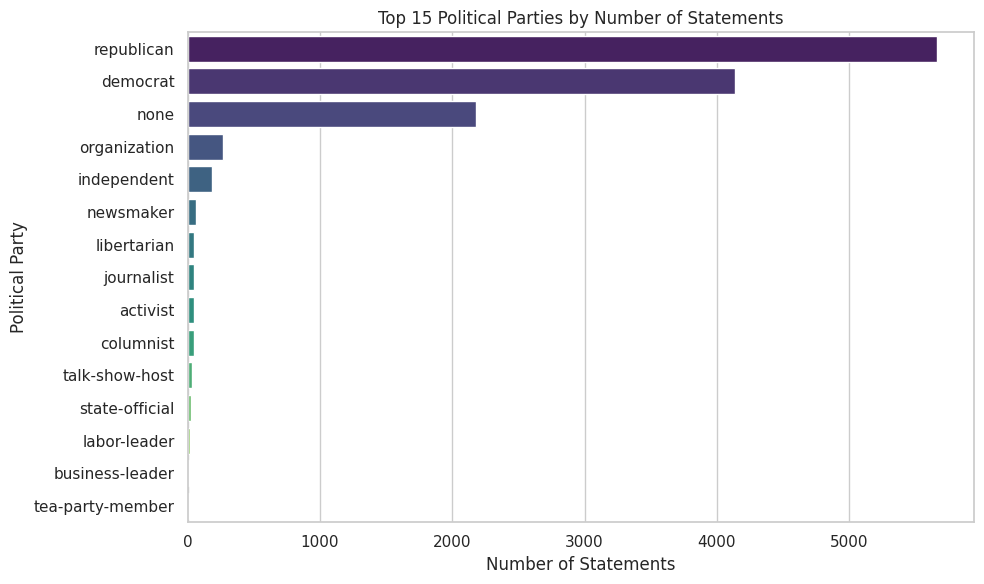

In [ ]:
# Party Distribution (Sta
plt.figure(figsize=(10,6))
party_counts = full_df["party"].value_counts().head(15)

sns.barplot(
    x=party_counts.values,
    y=party_counts.index,
    palette="viridis"
)
plt.title("Top 15 Political Parties by Number of Statements")
plt.xlabel("Number of Statements")
plt.ylabel("Political Party")
plt.tight_layout()
plt.show()

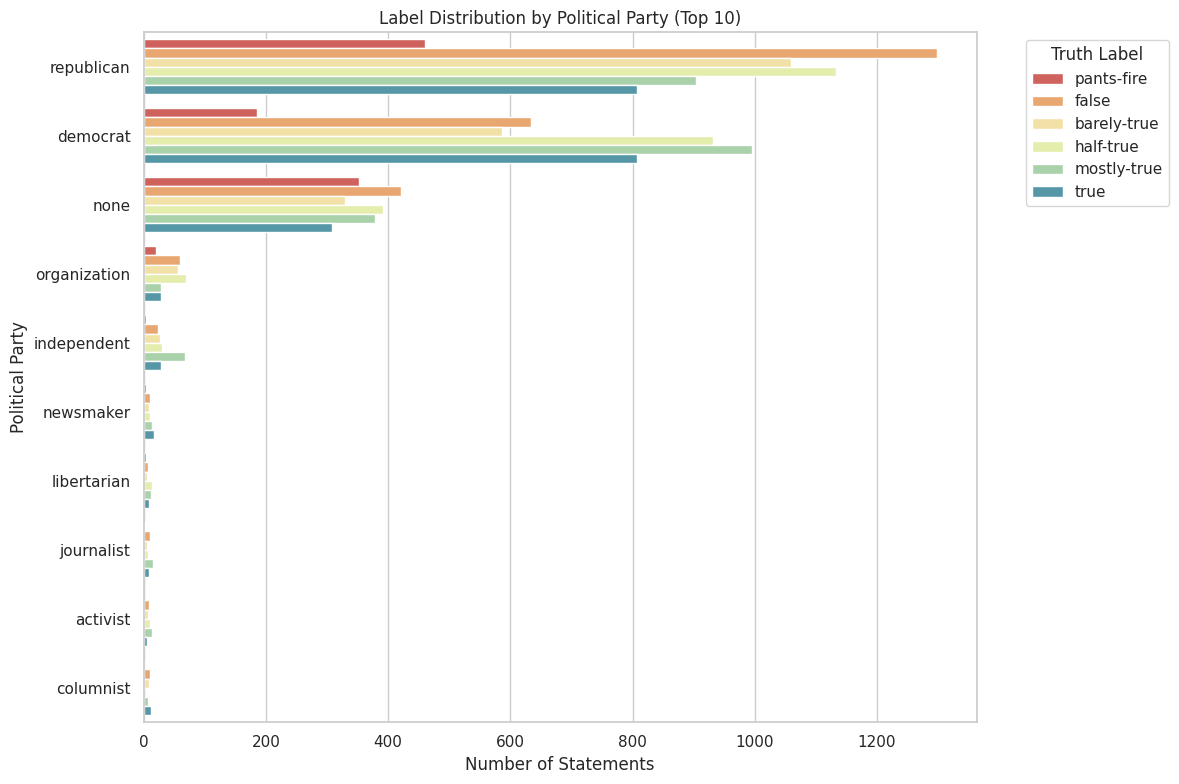

In [ ]:
#label distribution by party
plt.figure(figsize=(12,8))
label_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]

party_label_dist = (
    full_df.groupby(["party", "label"])
    .size()
    .reset_index(name="count")
)

sns.barplot(
    data=party_label_dist,
    x="count",
    y="party",
    hue="label",
    order=full_df["party"].value_counts().index[:10],  # Top 10 parties
    hue_order=label_order,
    palette="Spectral"
)
plt.title("Label Distribution by Political Party (Top 10)")
plt.xlabel("Number of Statements")
plt.ylabel("Political Party")
plt.legend(title="Truth Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1025294333.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


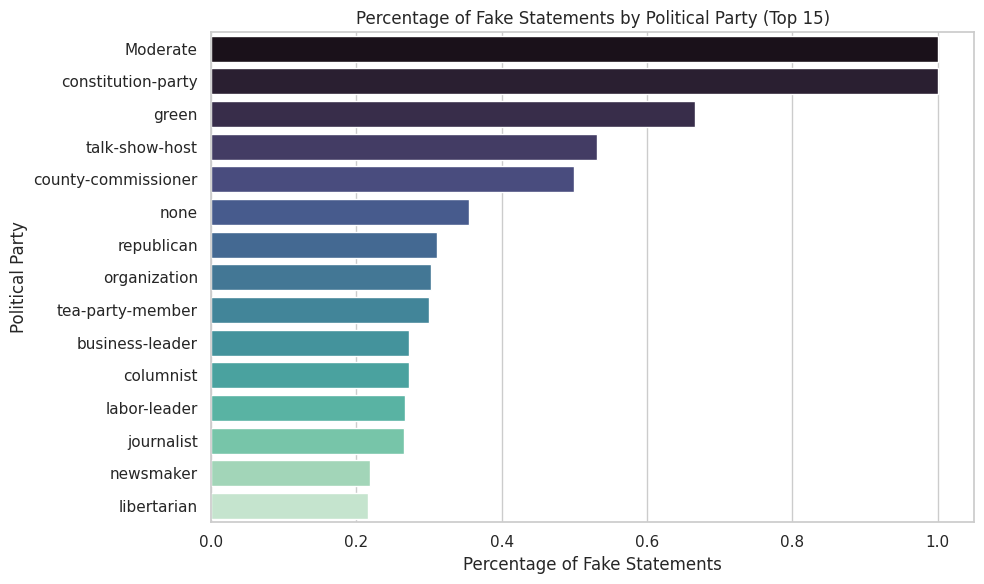

 Fake Statement Rates by Party:


party   is_fake
0              Moderate  1.000000
4    constitution-party  1.000000
10                green  0.666667
22       talk-show-host  0.531250
5   county-commissioner  0.500000
17                 none  0.354425
20           republican  0.310668
19         organization  0.303030
23     tea-party-member  0.300000
2       business-leader  0.272727
3             columnist  0.272727
13         labor-leader  0.266667
12           journalist  0.265306
16            newsmaker  0.218750
15          libertarian  0.215686

In [ ]:
#percentage of fake statements by party
fake_labels = ["false", "pants-fire", "barely_true"]

fake_rate = (
    full_df.assign(is_fake=full_df["label"].isin(fake_labels))
    .groupby("party")["is_fake"]
    .mean()
    .reset_index()
    .sort_values("is_fake", ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=fake_rate.head(15),
    x="is_fake",
    y="party",
    palette="mako"
)
plt.title("Percentage of Fake Statements by Political Party (Top 15)")
plt.xlabel("Percentage of Fake Statements")
plt.ylabel("Political Party")
plt.tight_layout()
plt.show()

print(" Fake Statement Rates by Party:")
display(fake_rate.head(15))


🔍 Correlation between average credibility and fake rate: -0.752


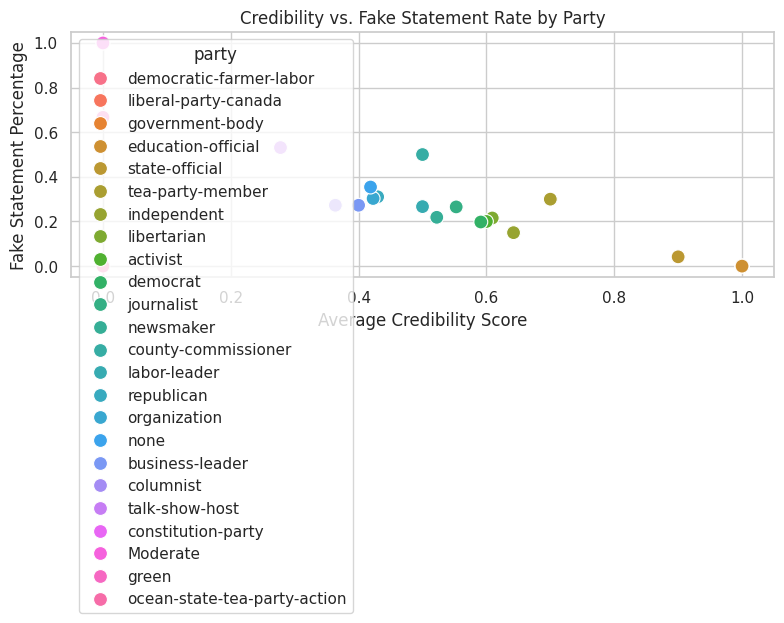

In [ ]:
party_summary = pd.merge(
    party_credibility,
    fake_rate,
    on="party",
    how="inner"
).rename(columns={"is_fake": "fake_percentage"})

# Correlation between credibility and fake rate
corr = party_summary["avg_credibility"].corr(party_summary["fake_percentage"])
print(f"🔍 Correlation between average credibility and fake rate: {corr:.3f}")

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=party_summary,
    x="avg_credibility",
    y="fake_percentage",
    hue="party",
    s=100,
    palette="husl"
)
plt.title("Credibility vs. Fake Statement Rate by Party")
plt.xlabel("Average Credibility Score")
plt.ylabel("Fake Statement Percentage")
plt.tight_layout()
plt.show()


subject

/tmp/ipython-input-1766128988.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


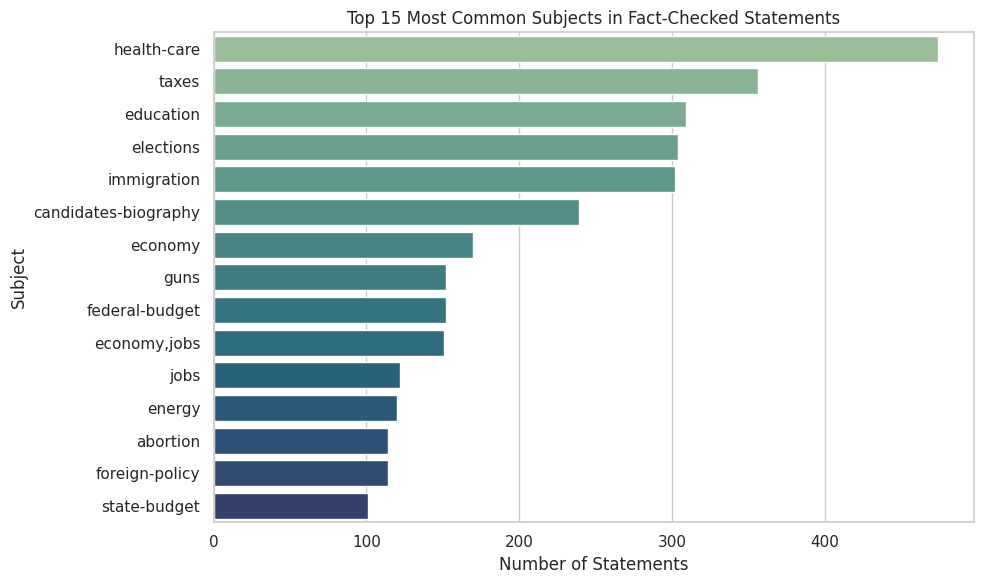

In [ ]:
#most frequent subject
plt.figure(figsize=(10,6))
top_subjects = (
    full_df["subject"]
    .value_counts()
    .head(15)
)

sns.barplot(
    x=top_subjects.values,
    y=top_subjects.index,
    palette="crest"
)
plt.title("Top 15 Most Common Subjects in Fact-Checked Statements")
plt.xlabel("Number of Statements")
plt.ylabel("Subject")
plt.tight_layout()
plt.show()


/tmp/ipython-input-430004938.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


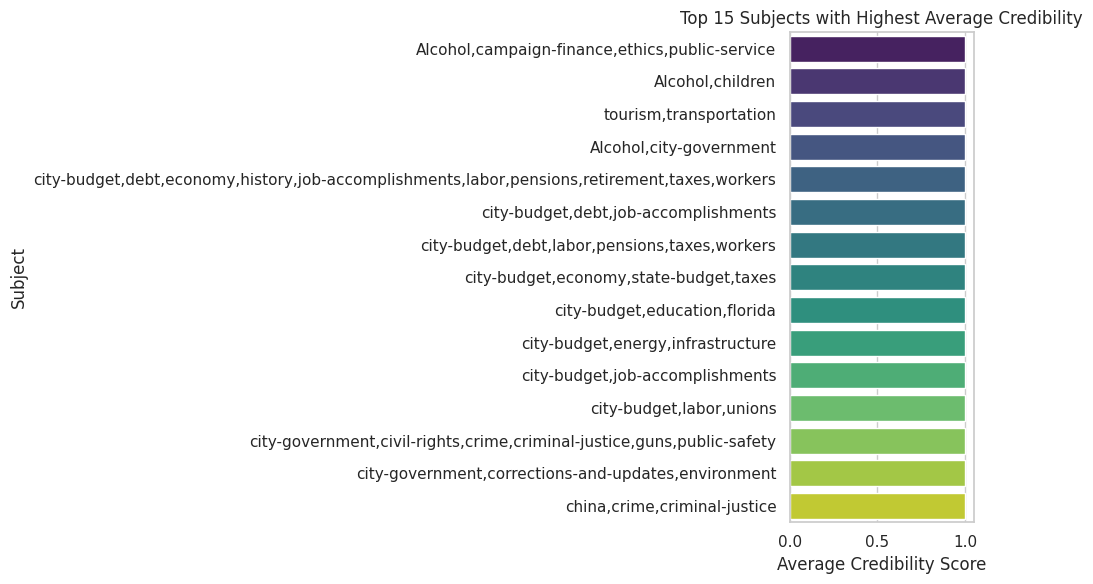

/tmp/ipython-input-430004938.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


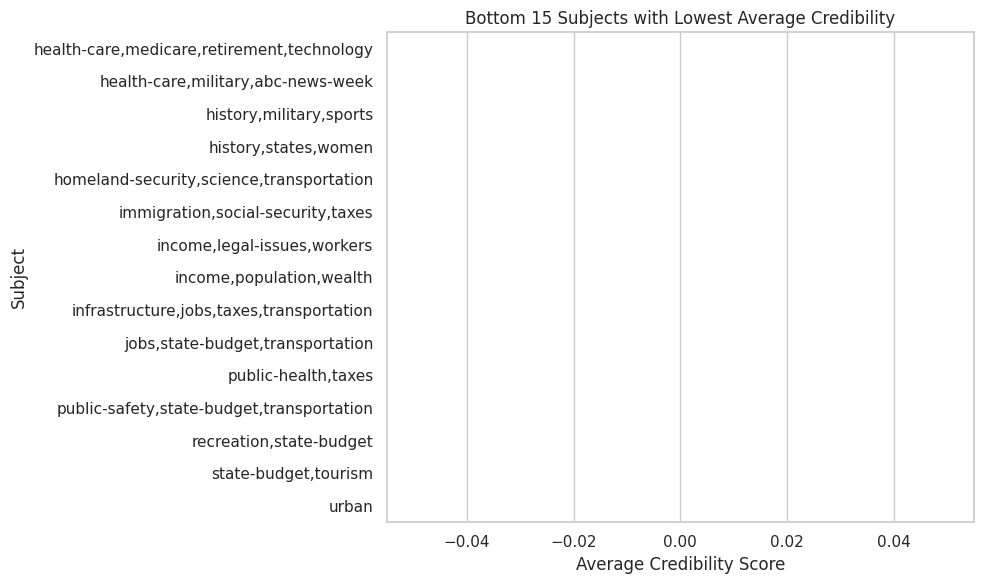

In [ ]:
#average credibility by subject
subject_credibility = (
    full_df.groupby("subject")["credibility_score"]
    .mean()
    .reset_index()
    .sort_values("credibility_score", ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=subject_credibility.head(15),
    x="credibility_score",
    y="subject",
    palette="viridis"
)
plt.title("Top 15 Subjects with Highest Average Credibility")
plt.xlabel("Average Credibility Score")
plt.ylabel("Subject")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(
    data=subject_credibility.tail(15),
    x="credibility_score",
    y="subject",
    palette="rocket"
)
plt.title("Bottom 15 Subjects with Lowest Average Credibility")
plt.xlabel("Average Credibility Score")
plt.ylabel("Subject")
plt.tight_layout()
plt.show()


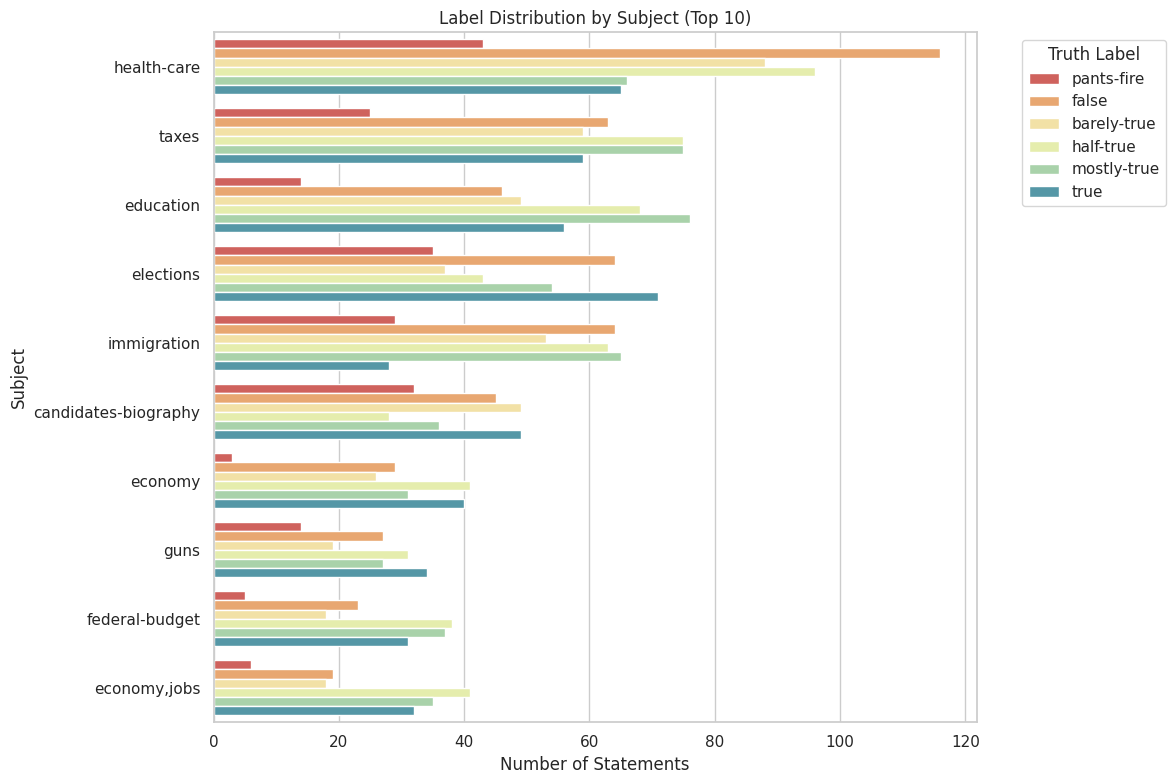

In [ ]:
#label distribution by subject
plt.figure(figsize=(12,8))
subject_label_dist = (
    full_df.groupby(["subject", "label"])
    .size()
    .reset_index(name="count")
)

label_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]

sns.barplot(
    data=subject_label_dist,
    x="count",
    y="subject",
    hue="label",
    order=full_df["subject"].value_counts().index[:10],  # Top 10 subjects
    hue_order=label_order,
    palette="Spectral"
)
plt.title("Label Distribution by Subject (Top 10)")
plt.xlabel("Number of Statements")
plt.ylabel("Subject")
plt.legend(title="Truth Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


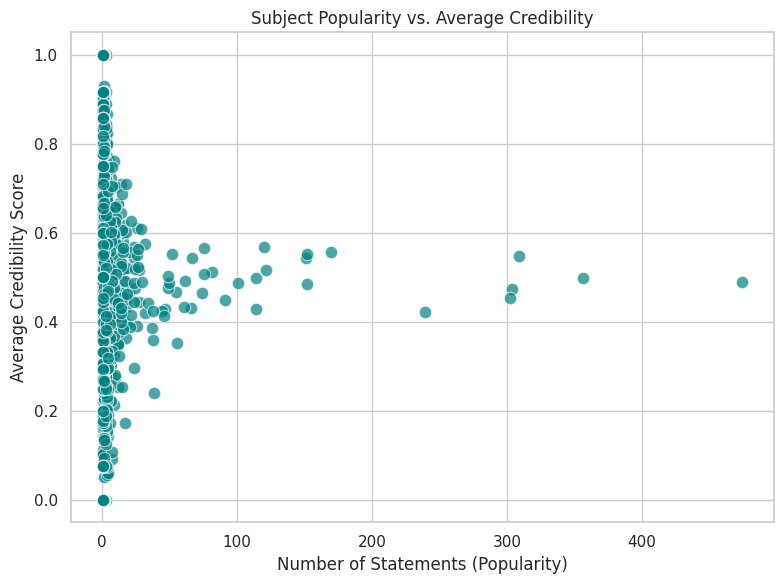

 Correlation between subject popularity and average credibility: 0.001


In [ ]:
#relationship between popularity and credibilty
subject_popularity_cred = (
    full_df.groupby("subject")
    .agg(
        num_statements=("subject", "count"),
        avg_credibility=("credibility_score", "mean")
    )
    .reset_index()
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=subject_popularity_cred,
    x="num_statements",
    y="avg_credibility",
    s=80,
    alpha=0.7,
    color="teal"
)
plt.title("Subject Popularity vs. Average Credibility")
plt.xlabel("Number of Statements (Popularity)")
plt.ylabel("Average Credibility Score")
plt.tight_layout()
plt.show()

corr = subject_popularity_cred["num_statements"].corr(subject_popularity_cred["avg_credibility"])
print(f" Correlation between subject popularity and average credibility: {corr:.3f}")


In [ ]:
#word cloud - fake vs real statements
fake_labels = ["pants-fire", "false", "barely-true"]
real_labels = ["half-true", "mostly-true", "true"]

full_df["truth_binary"] = full_df["label"].apply(lambda x: "fake" if x in fake_labels else "true")

In [ ]:
from wordcloud import WordCloud


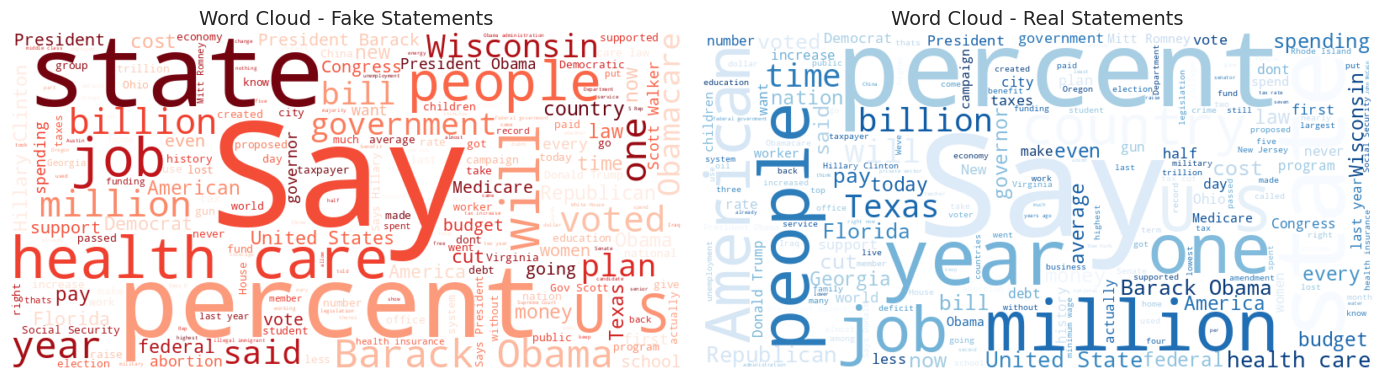

In [ ]:
# Combine text per category
fake_text = " ".join(full_df[full_df["truth_binary"] == "fake"]["statement"].dropna().values)
real_text = " ".join(full_df[full_df["truth_binary"] == "true"]["statement"].dropna().values)

# Generate word clouds
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
wc_fake = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(fake_text)
plt.imshow(wc_fake, interpolation="bilinear")
plt.title("Word Cloud - Fake Statements", fontsize=14)
plt.axis("off")

plt.subplot(1,2,2)
wc_real = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(real_text)
plt.imshow(wc_real, interpolation="bilinear")
plt.title("Word Cloud - Real Statements", fontsize=14)
plt.axis("off")

plt.tight_layout()
plt.show()

/tmp/ipython-input-3139905252.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="bigram", data=df_fake_bi, palette="Reds_r")
/tmp/ipython-input-3139905252.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="bigram", data=df_real_bi, palette="Blues_r")


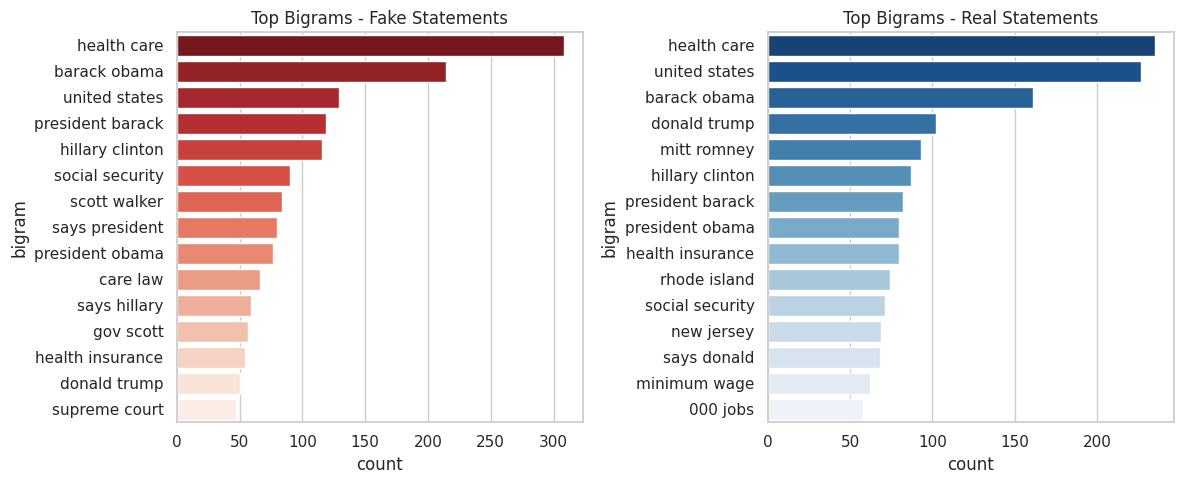

In [ ]:
# n-gram frequency analysis(fake vs real)from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top bigrams and trigrams
fake_bigrams = get_top_ngrams(full_df[full_df["truth_binary"] == "fake"]["statement"], (2,2), 15)
real_bigrams = get_top_ngrams(full_df[full_df["truth_binary"] == "true"]["statement"], (2,2), 15)

# Convert to DataFrame for plotting
df_fake_bi = pd.DataFrame(fake_bigrams, columns=["bigram", "count"])
df_real_bi = pd.DataFrame(real_bigrams, columns=["bigram", "count"])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x="count", y="bigram", data=df_fake_bi, palette="Reds_r")
plt.title("Top Bigrams - Fake Statements")

plt.subplot(1,2,2)
sns.barplot(x="count", y="bigram", data=df_real_bi, palette="Blues_r")
plt.title("Top Bigrams - Real Statements")

plt.tight_layout()
plt.show()

/tmp/ipython-input-4186275227.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_df, x="truth_binary", y="readability", palette="coolwarm")


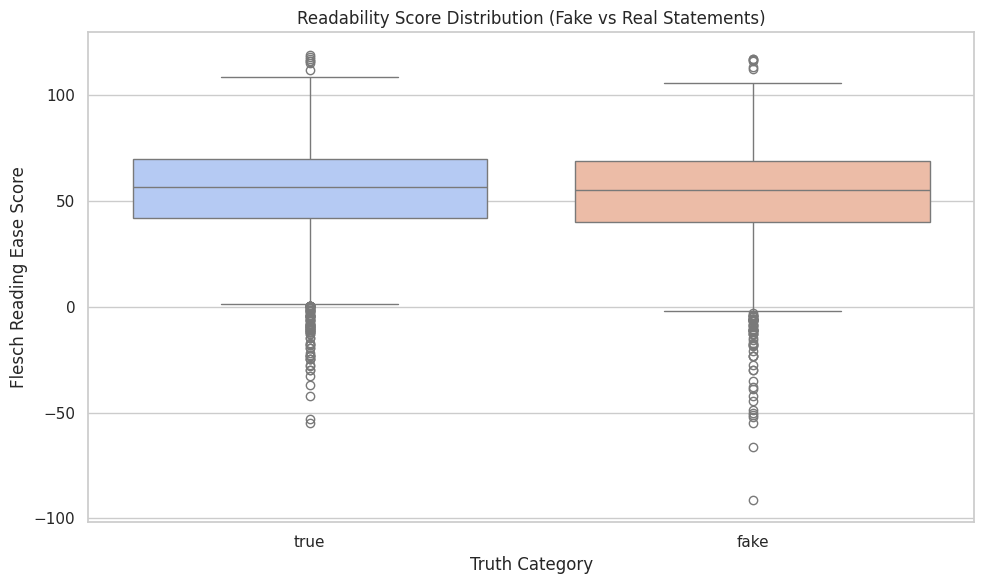

In [ ]:
# Text readability and complexity
import textstat

full_df["word_count"] = full_df["statement"].apply(lambda x: len(str(x).split()))
full_df["avg_word_len"] = full_df["statement"].apply(lambda x: np.mean([len(w) for w in str(x).split() if len(w)>0]))
full_df["readability"] = full_df["statement"].apply(lambda x: textstat.flesch_reading_ease(str(x)))

# Compare across truth categories
plt.figure(figsize=(10,6))
sns.boxplot(data=full_df, x="truth_binary", y="readability", palette="coolwarm")
plt.title("Readability Score Distribution (Fake vs Real Statements)")
plt.xlabel("Truth Category")
plt.ylabel("Flesch Reading Ease Score")
plt.tight_layout()
plt.show()

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.9 MB/s eta 0:00:00


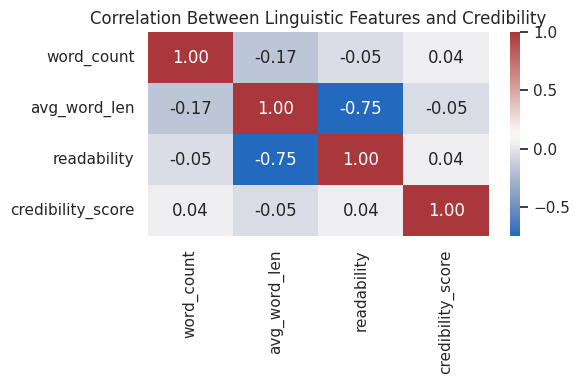

In [ ]:
#correlation between linguistic features and credibility
linguistic_corr = full_df[["word_count", "avg_word_len", "readability", "credibility_score"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(linguistic_corr, annot=True, cmap="vlag", fmt=".2f")
plt.title("Correlation Between Linguistic Features and Credibility")
plt.tight_layout()
plt.show()

In [ ]:
# Compute total historical statements per row
hist_cols = [
    "barely_true_counts", "false_counts", "half_true_counts",
    "mostly_true_counts", "pants_on_fire_counts"
]

full_df["total_historical"] = full_df[hist_cols].sum(axis=1)

# Historical accuracy = proportion of mostly true + half true
full_df["historical_accuracy"] = (
    (full_df["mostly_true_counts"] + full_df["half_true_counts"]) /
    full_df["total_historical"].replace(0, np.nan)
)

# Replace NaNs (for speakers with no history)
full_df["historical_accuracy"] = full_df["historical_accuracy"].fillna(0)

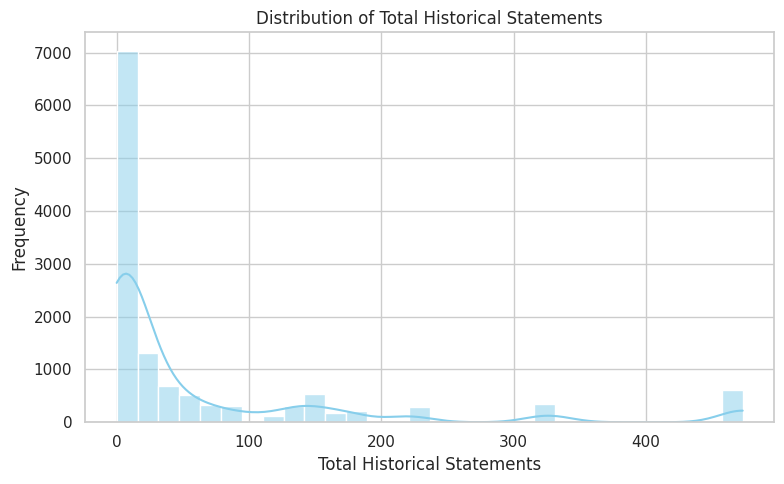

In [ ]:
# distribution of total historical statements
plt.figure(figsize=(8,5))
sns.histplot(full_df["total_historical"], bins=30, kde= True, color="skyblue")
plt.title("Distribution of Total Historical Statements")
plt.xlabel("Total Historical Statements")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Many speakers have few or no historical records.

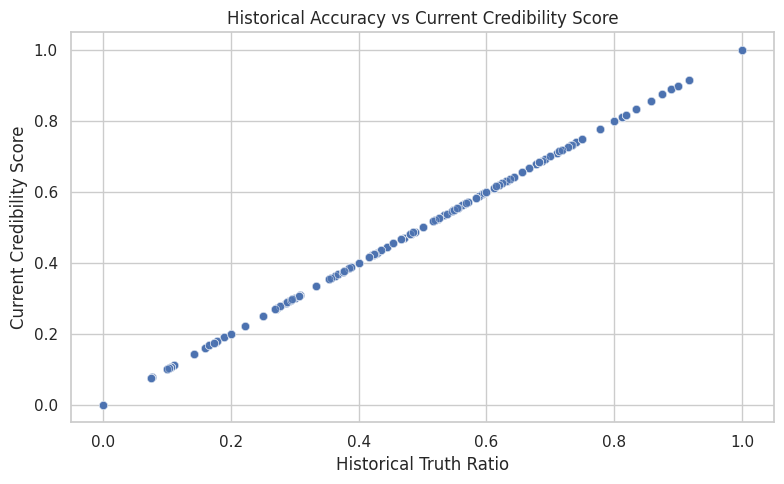

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=full_df,
    x="historical_accuracy",
    y="credibility_score",
    alpha=0.6
)
plt.title("Historical Accuracy vs Current Credibility Score")
plt.xlabel("Historical Truth Ratio")
plt.ylabel("Current Credibility Score")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4051606881.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hist_summary, x="historical_label", y="count", palette="crest")


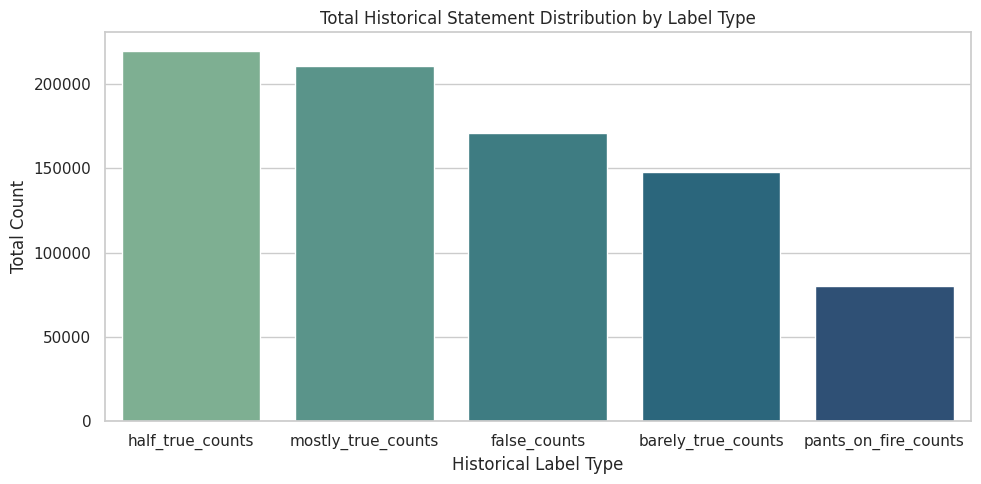

In [ ]:
hist_summary = (
    full_df[hist_cols]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
hist_summary.columns = ["historical_label", "count"]

plt.figure(figsize=(10,5))
sns.barplot(data=hist_summary, x="historical_label", y="count", palette="crest")
plt.title("Total Historical Statement Distribution by Label Type")
plt.xlabel("Historical Label Type")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2921217645.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hist_corr.values, y=hist_corr.index, palette="vlag")


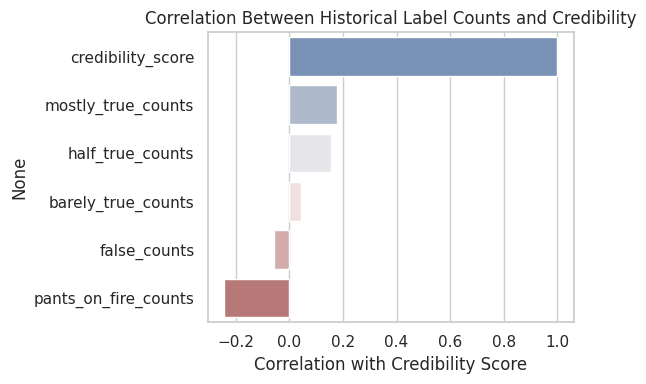

credibility_score       1.000000
mostly_true_counts      0.177378
half_true_counts        0.156099
barely_true_counts      0.044414
false_counts           -0.057959
pants_on_fire_counts   -0.242777
Name: credibility_score, dtype: float64

In [ ]:
#Correlation Between Historical Counts and Credibility
hist_corr = full_df[hist_cols + ["credibility_score"]].corr()["credibility_score"].sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=hist_corr.values, y=hist_corr.index, palette="vlag")
plt.title("Correlation Between Historical Label Counts and Credibility")
plt.xlabel("Correlation with Credibility Score")
plt.tight_layout()
plt.show()

hist_corr

In [ ]:
#Speaker Historical Accuracy Ranking
speaker_history = (
    full_df.groupby("speaker")[["historical_accuracy", "credibility_score"]]
    .mean()
    .reset_index()
    .sort_values(by="historical_accuracy", ascending=False)
)

speaker_history.head(10)

speaker  historical_accuracy  credibility_score
3                            AARP                  1.0                1.0
8                   H204TEXAS-PAC                  1.0                1.0
20                    actionaid-k                  1.0                1.0
16         accountability-project                  1.0                1.0
14                   abel-collins                  1.0                1.0
10                  Kiplinger-com                  1.0                1.0
2086  mayors-against-illegal-guns                  1.0                1.0
2085                 maxey-scherr                  1.0                1.0
2080           matthew-rothschild                  1.0                1.0
2078                 matthew-dowd                  1.0                1.0

Correlation Analysis between features and labels

In [ ]:
#encode labels numerically
numeric_features = [
    "label_encoded", "credibility_score", "word_count", "avg_word_len",
    "readability", "total_historical", "historical_accuracy",
    "barely_true_counts", "false_counts", "half_true_counts",
    "mostly_true_counts", "pants_on_fire_counts"
]
corr_matrix = full_df[numeric_features].corr()

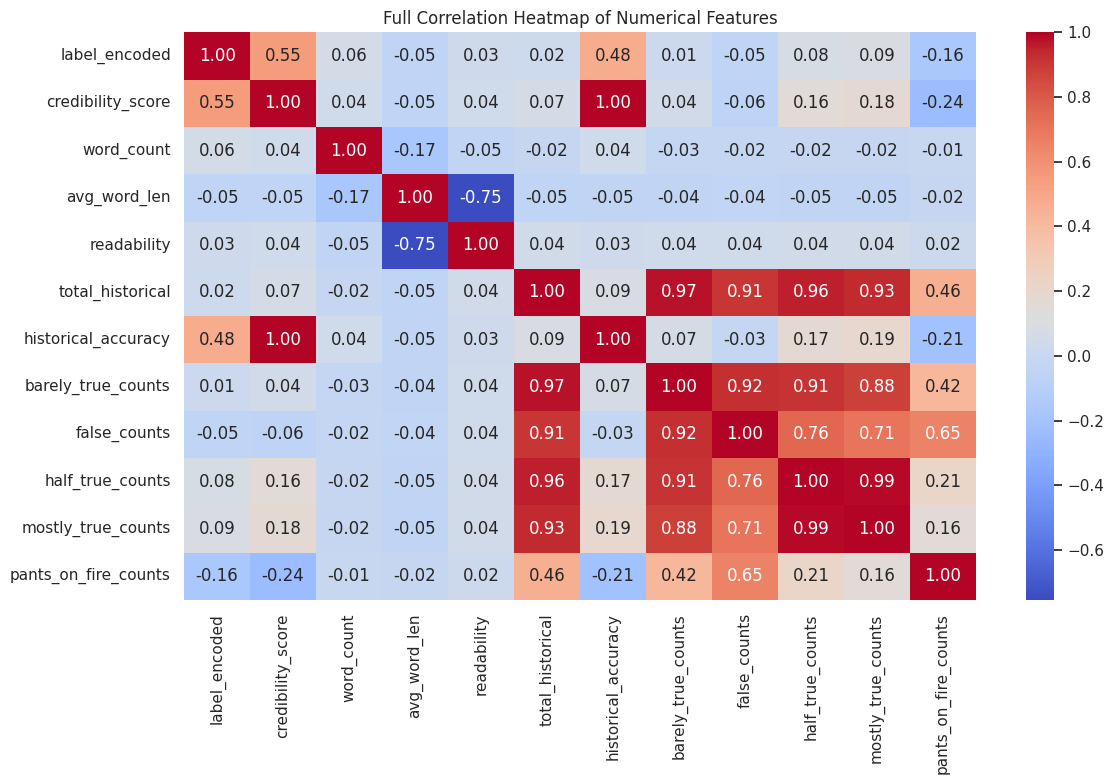

In [ ]:
# full correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Full Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2101933136.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_corr.values, y=label_corr.index, palette="vlag")


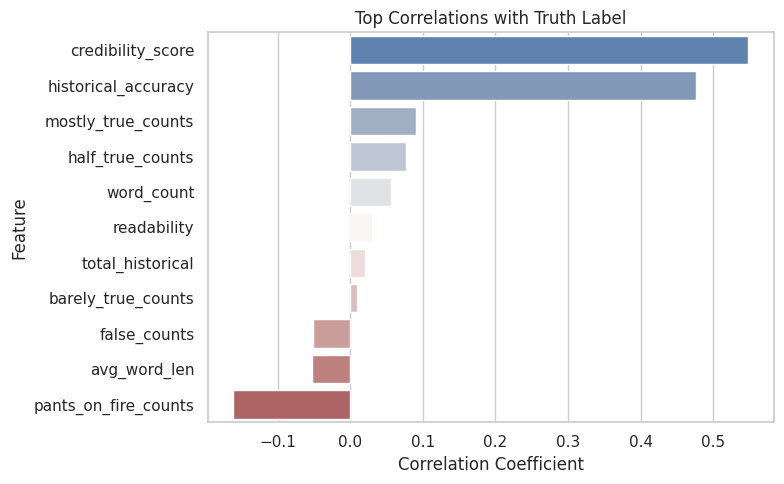

credibility_score       0.548140
historical_accuracy     0.475721
mostly_true_counts      0.090545
half_true_counts        0.077072
word_count              0.055772
readability             0.030486
total_historical        0.020316
barely_true_counts      0.008810
false_counts           -0.051829
avg_word_len           -0.052962
pants_on_fire_counts   -0.160799
Name: label_encoded, dtype: float64

In [ ]:
#top correlations with Truth Label
label_corr = corr_matrix["label_encoded"].sort_values(ascending=False).drop("label_encoded")

plt.figure(figsize=(8,5))
sns.barplot(x=label_corr.values, y=label_corr.index, palette="vlag")
plt.title("Top Correlations with Truth Label")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

label_corr

/tmp/ipython-input-3892159818.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


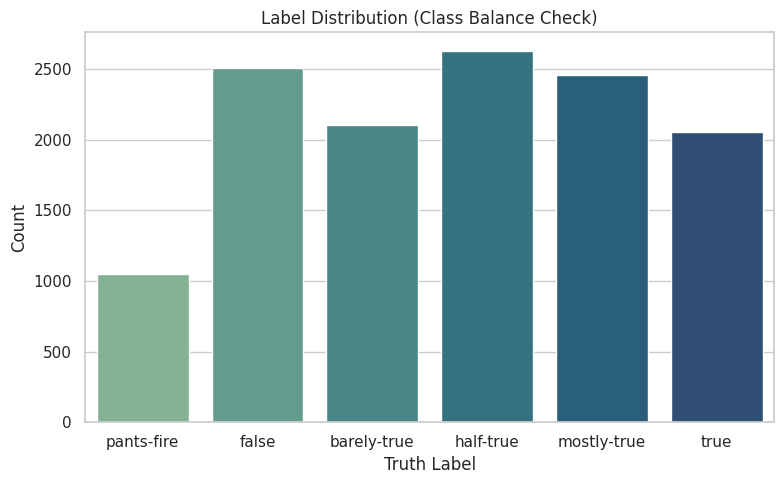

 Class Distribution:


In [ ]:
# class balance and imbalance check


# Define the label map again (ensures consistency)
label_map = {
    "pants-fire": 0,
    "false": 1,
    "barely-true": 2,
    "half-true": 3,
    "mostly-true": 4,
    "true": 5
}

# Countplot to visualize distribution of all six classes
plt.figure(figsize=(8,5))
sns.countplot(
    x="label",
    data=full_df,
    order=label_map.keys(),
    palette="crest"
)
plt.title("Label Distribution (Class Balance Check)")
plt.xlabel("Truth Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Show numerical class distribution
label_counts = full_df["label"].value_counts()
label_percentages = full_df["label"].value_counts(normalize=True) * 100

balance_df = pd.DataFrame({
    "Label": label_counts.index,
    "Count": label_counts.values,
    "Percentage": label_percentages.values.round(2)
})

print(" Class Distribution:")




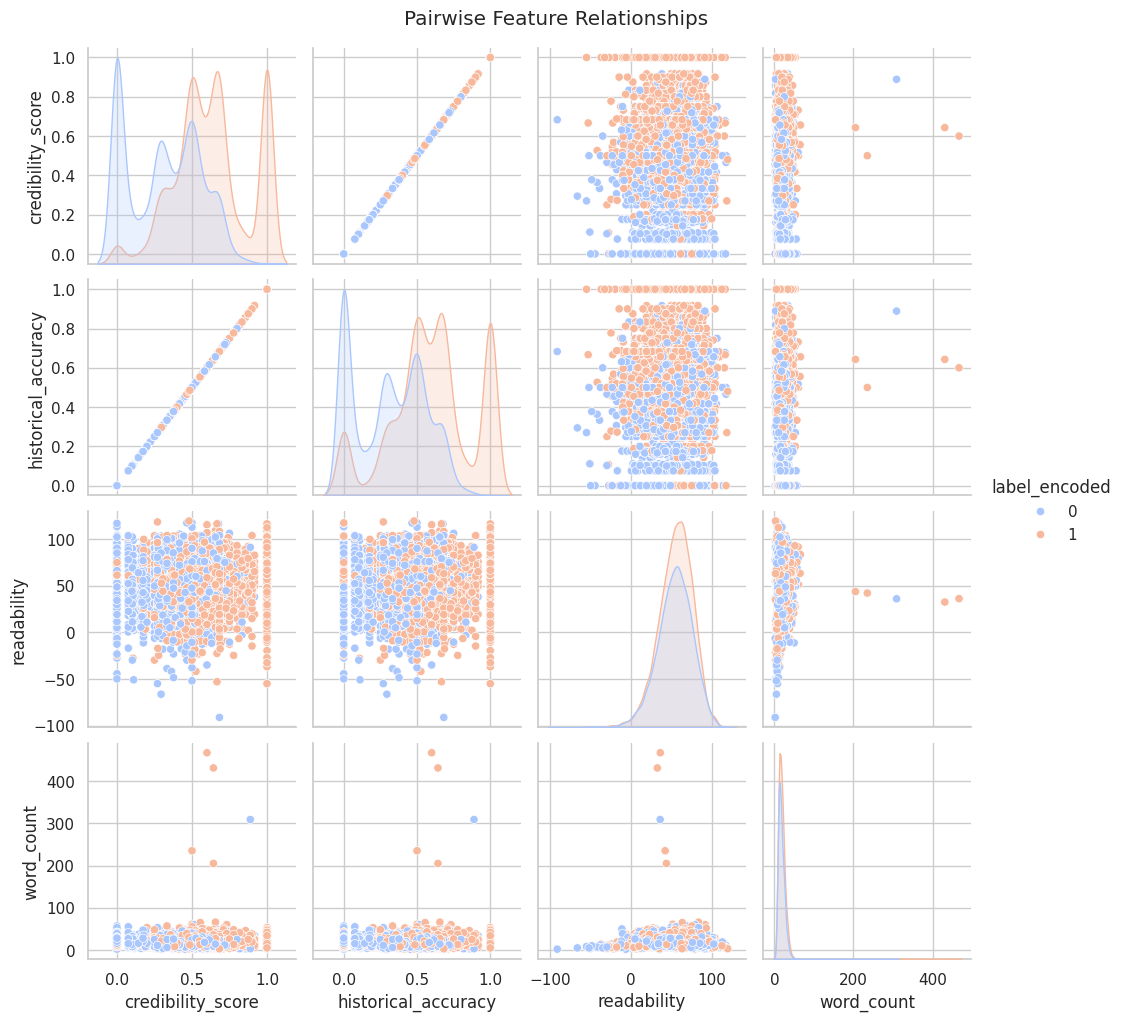

In [ ]:
# feature interdependence
sns.pairplot(
    full_df[["credibility_score", "historical_accuracy", "readability", "word_count", "label_encoded"]],
    hue="label_encoded",
    palette="coolwarm"
)
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

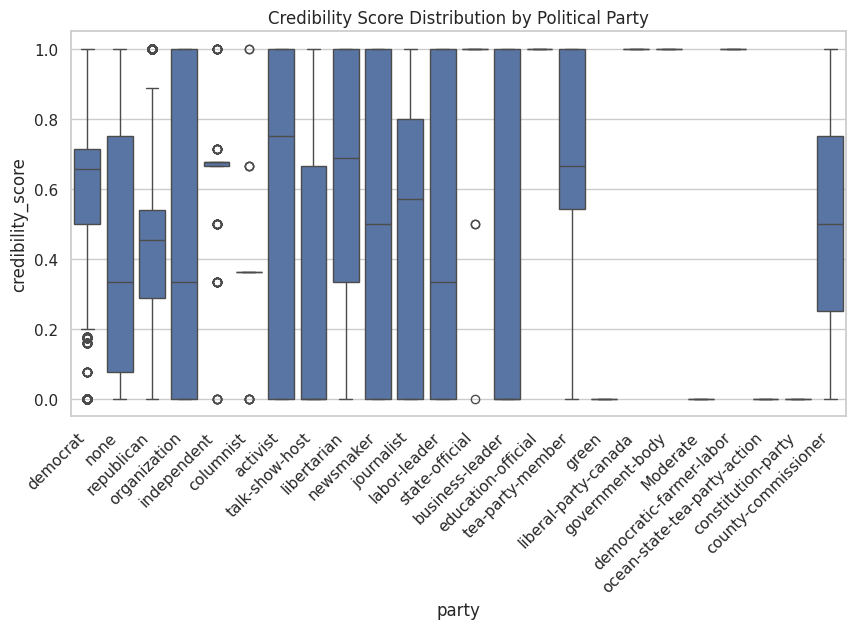

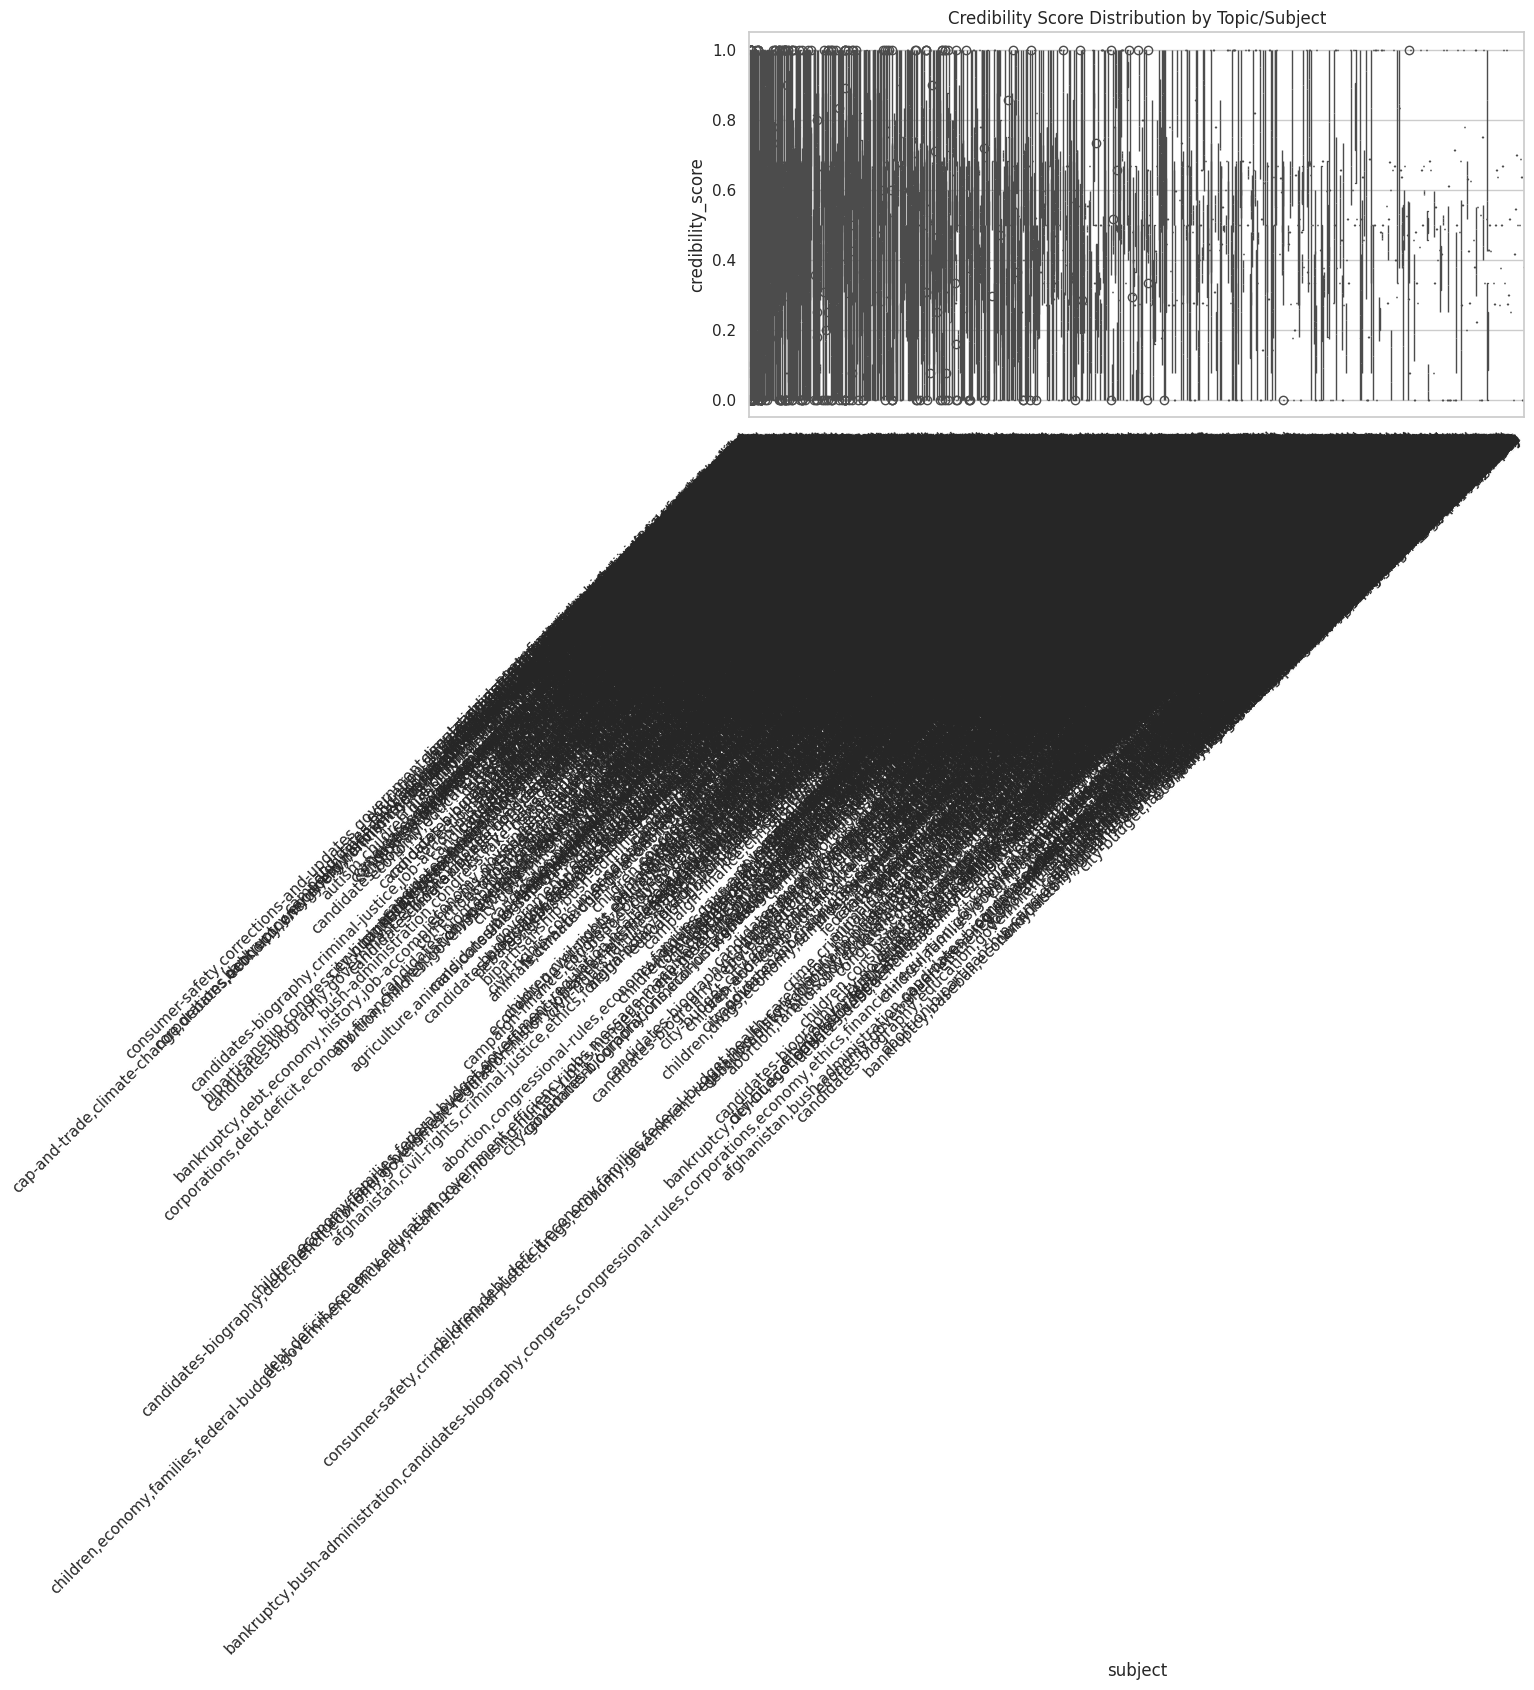

In [ ]:
#cross feature relationships
plt.figure(figsize=(10,5))
sns.boxplot(data=full_df, x='party', y='credibility_score')
plt.title("Credibility Score Distribution by Political Party")
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=full_df, x='subject', y='credibility_score')
plt.title("Credibility Score Distribution by Topic/Subject")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
full_df.to_csv("clean_liar.csv", index=False)

print("dataset saved")

dataset saved
